##### **Exploratory Analysis of ATP Tennis Match Outcomes**


In [1]:
import pandas as pd
import numpy as np
import glob 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

**Collating ATP match level data downloaded from https://github.com/JeffSackmann/tennis_atp.git**

In [ ]:
# Loading all downloded CSV files
folder_path='./data'
# Initializing an empty list to hold dataframes
data=[]
files=glob.glob(os.path.join(folder_path,'*.csv'))
# Looping through each file and reading it into a dataframe
for file in files:
    records=pd.read_csv(file)
    records['tourney_date'] = pd.to_datetime(records['tourney_date'],format='%Y%m%d')
    data.append(records)
    print(f"{file}: Records: {records.shape[0]}")
# Concatenating all dataframes into a single dataframe
df=pd.concat(data,ignore_index=True)

./data\atp_matches_2017.csv: Records: 2911
./data\atp_matches_2018.csv: Records: 2897
./data\atp_matches_2019.csv: Records: 2806
./data\atp_matches_2020.csv: Records: 1462
./data\atp_matches_2021.csv: Records: 2733
./data\atp_matches_2022.csv: Records: 2917
./data\atp_matches_2023.csv: Records: 2986
./data\atp_matches_2024.csv: Records: 3076


**Step 1: Exploratory Data Analysis**

In [3]:
# Converting 'tourney_date' to datetime format and displaying the date range
df['tourney_date'] = pd.to_datetime(df['tourney_date'], format='%Y%m%d')
print(f"ATP match stats from: {df['tourney_date'].min().strftime('%Y')} to {df['tourney_date'].max().strftime('%Y')}")
# No of players
print(f"Number of unique players: {df['winner_name'].nunique() + df['loser_name'].nunique()}")

ATP match stats from: 2017 to 2024
Number of unique players: 1688


In [4]:
# Checking for missing values
df.isna().sum()

tourney_id                0
tourney_name              0
surface                  53
draw_size                 0
tourney_level             0
tourney_date              0
match_num                 0
winner_id                 0
winner_seed           12777
winner_entry          18500
winner_name               0
winner_hand               0
winner_ht               106
winner_ioc                0
winner_age                3
loser_id                  0
loser_seed            16402
loser_entry           16815
loser_name                0
loser_hand                1
loser_ht                297
loser_ioc                 0
loser_age                 3
score                     0
best_of                   0
round                     0
minutes                1107
w_ace                   735
w_df                    735
w_svpt                  735
w_1stIn                 735
w_1stWon                735
w_2ndWon                735
w_SvGms                 735
w_bpSaved               735
w_bpFaced           

In [5]:
# For seed, imputing with 0 as players can be unseeded
df['winner_seed']=df['winner_seed'].fillna(0)
df['loser_seed']=df['loser_seed'].fillna(0)
# For entry, assigning 'Unseeded'
df['winner_entry']=df['winner_entry'].fillna('Unseeded')
df['loser_entry']=df['loser_entry'].fillna('Unseeded')
# Height is imputed using global median due to sparsity and secondary importance.
df['winner_ht']=df['winner_ht'].fillna(188)
df['loser_ht']=df['loser_ht'].fillna(188)
# For walkovers/Retirements and No stats filling with 0
stat_cols = ['w_ace','w_df','w_svpt','w_1stIn','w_1stWon','w_2ndWon','w_SvGms',
             'w_bpSaved','w_bpFaced','l_ace','l_df','l_svpt','l_1stIn','l_1stWon',
             'l_2ndWon','l_SvGms','l_bpSaved','l_bpFaced','minutes']
df[stat_cols] = df[stat_cols].fillna(0)


In [6]:
# For ranking using forward fill method
def fill_player_ranks(df):
    for player_type in ['winner', 'loser']:
        player_id = f"{player_type}_id"
        rank = f"{player_type}_rank"
        df = df.sort_values('tourney_date')
        df[rank] = df.groupby(player_id)[rank].ffill()
    return df
df = fill_player_ranks(df)
df[['winner_rank', 'loser_rank']] = df[['winner_rank', 'loser_rank']].fillna(1000)

In [7]:
print("Hard Court Grand Slam Tournaments:", df['tourney_name'].nunique())
# Standardizing tournament name for US Open
df['tourney_name'] = df['tourney_name'].replace('Us Open', 'US Open')
# Validating the unique tournament names 
print("Hard Court Grand Slam Tournaments:", df['tourney_name'].nunique())

Hard Court Grand Slam Tournaments: 616
Hard Court Grand Slam Tournaments: 615


In [8]:
df.columns

Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'winner_id', 'winner_seed', 'winner_entry',
       'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
       'loser_id', 'loser_seed', 'loser_entry', 'loser_name', 'loser_hand',
       'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of', 'round',
       'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt',
       'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced',
       'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points'],
      dtype='object')

**Step 2: Feature Engineering**

In [9]:
# Transforming winner/loser format to player A/player B format
df['player_A']=df['winner_name']
df['player_B']=df['loser_name']
df['A_wins']=1
df_rev = df.copy()
df_rev["player_A"] = df["loser_name"]
df_rev["player_B"] = df["winner_name"]
df_rev["A_wins"] = 0
df = pd.concat([df, df_rev], ignore_index=True)

In [10]:
# Adding year column
df.year=df.tourney_date.dt.year

In [11]:
# Surface encoding to run a conditional ELO
df = pd.get_dummies(df, columns=["surface"], drop_first=True)


In [12]:
# Tournament encoding
level_map = {
    "G": "GrandSlam",
    "M": "Masters",
    "A": "ATP500",
    "B": "ATP250"
}
df["tourney_level"] = df["tourney_level"].map(level_map)
df = pd.get_dummies(df, columns=["tourney_level"], drop_first=True)


In [13]:
# Ranking difference feature
df["rank_diff"] = df["winner_rank"] - df["loser_rank"]
df["rank_points_diff"] = (
    df["winner_rank_points"] - df["loser_rank_points"]
)
# Physical features difference
df["age_diff"] = df["winner_age"] - df["loser_age"]
df["height_diff"] = df["winner_ht"] - df["loser_ht"]

**Step 3: Visualisations**

**Does a higher 1st-serve win percentage correlate with match victory?**
$$
\text{1st Serve Win \%} = \frac{\text{1st Serve Points Won}}{\text{1st Serve Points In}}
$$

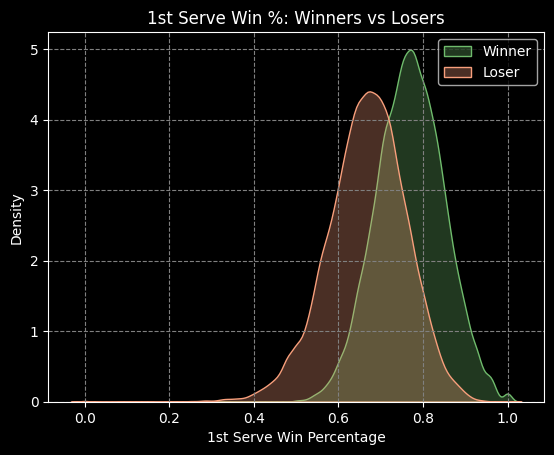

In [14]:
df["w_1stServeWinPct"] = df["w_1stWon"] / df["w_1stIn"]
df["l_1stServeWinPct"] = df["l_1stWon"] / df["l_1stIn"]
plt.style.use("dark_background")
sns.kdeplot(df["w_1stServeWinPct"], label="Winner",color="#6FBB6CB9",fill=True,alpha=0.3)
sns.kdeplot(df["l_1stServeWinPct"], label="Loser",color="#f89f7c",fill=True,alpha=0.3)
plt.legend()
plt.grid(linestyle='--', color='gray')
plt.title("1st Serve Win %: Winners vs Losers")
plt.xlabel("1st Serve Win Percentage")
plt.show()


- The winner distribution is clearly right skewed relative to the loser.
- Winners cluster around ~0.75 - 0.80 1st serve win %
- Losers cluster lower around ~0.65 - 0.70

**Conclusion:**
Higher 1st serve win percentage is **strongly associated** with match victory at the descriptive level.

**How dominant is player ranking in determining match victory?**

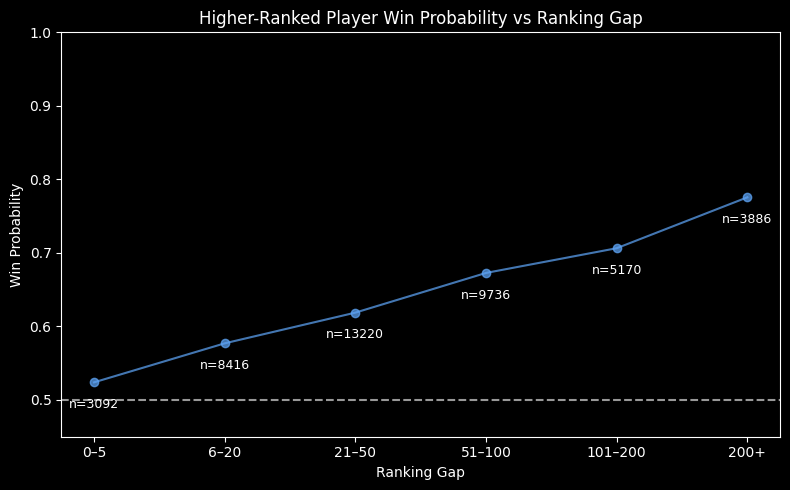

In [17]:
plt.style.use("dark_background")
# Analyzing win probability based on ranking gap
df = df.dropna(subset=["winner_rank", "loser_rank"]).copy()
df["rank_gap"] = (df["winner_rank"] - df["loser_rank"]).abs()
df["favorite_win"] = (df["winner_rank"] < df["loser_rank"]).astype(int)
bins = [0, 5, 20, 50, 100, 200, 2000]
labels = ["0–5", "6–20", "21–50", "51–100", "101–200", "200+"]
df["gap_bin"] = pd.cut(df["rank_gap"], bins=bins, labels=labels)
win_rate = df.groupby("gap_bin")["favorite_win"].mean()
counts = df.groupby("gap_bin").size()
plt.figure(figsize=(8,5))
plt.plot(
    win_rate.index.astype(str),
    win_rate.values,
    marker="o",
    color="#5EA5F7B8"
)
plt.axhline(0.5, linestyle="--", alpha=0.6)
plt.ylim(0.45, 1.0)
for i, c in enumerate(counts):
    plt.text(i, win_rate.iloc[i] - 0.035, f"n={c}", ha="center", fontsize=9)
plt.title("Higher-Ranked Player Win Probability vs Ranking Gap")
plt.xlabel("Ranking Gap")
plt.ylabel("Win Probability")
plt.tight_layout()
plt.show()


- As the ranking gap increases, the win probability of the higher-ranked player rises steadily from near parity in closely matched contests (≈52% for gaps of 0–5) to roughly 74% for gaps above 200. However, the probability never approaches certainty, indicating persistent outcome variability even in large mismatches.

##### Exporting the cleaned dataset for modelling

In [16]:
df.to_csv('./atp_matches_processed.csv', index=False)

**Conclusion:**

- This exploratory analysis examined ATP match-level data to understand basic relationships between player ranking, match performance, and outcomes. 
- The results show that ranking provides a strong but imperfect signal of match victory, while match statistics such as serve performance are descriptive and observed only after the match.
- Given the persistent uncertainty observed across matches, further insight requires a modeling approach that estimates player strength and quantifies outcome variability. 
- The next stage of this project focuses on predictive modeling using Elo ratings and Monte Carlo simulation.
